In [1]:
import numpy as np
import numpy.random as rd
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import scipy.optimize as opt

import pybinding as pb

In [2]:
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['axes.linewidth'] = 1.5
plt.rcParams["figure.dpi"] = 200
# sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=10)

In [3]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler("color",["r","b","k","#ffb703","#fb8500"])
Mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"])

Mycmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["b","r"])

#plt.rcParams['axes.prop_cycle'] = plt.cycler("color",["#ffba08","#e85d04","#d00000","#6a040f","#03071e"])
#Mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"])

### Lattice

In [4]:
def create_lattice(N):
    a1 = np.array([3,np.sqrt(3)])*0.5
    a2 = np.array([3,-np.sqrt(3)])*0.5
    X = np.zeros((N,N))
    Y = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            X[i,j] = (i*a1[0]+j*a2[0])
            Y[i,j] = (i*a1[1]+j*a2[1])
    return X,Y

def spins_generator(N):
    """
    Generates a 2D grid of spins, the X and Y direction are enumerated in the tex file.
    """
    spins = rd.choice(np.array([-1,1]),size = (N,N))
    return spins

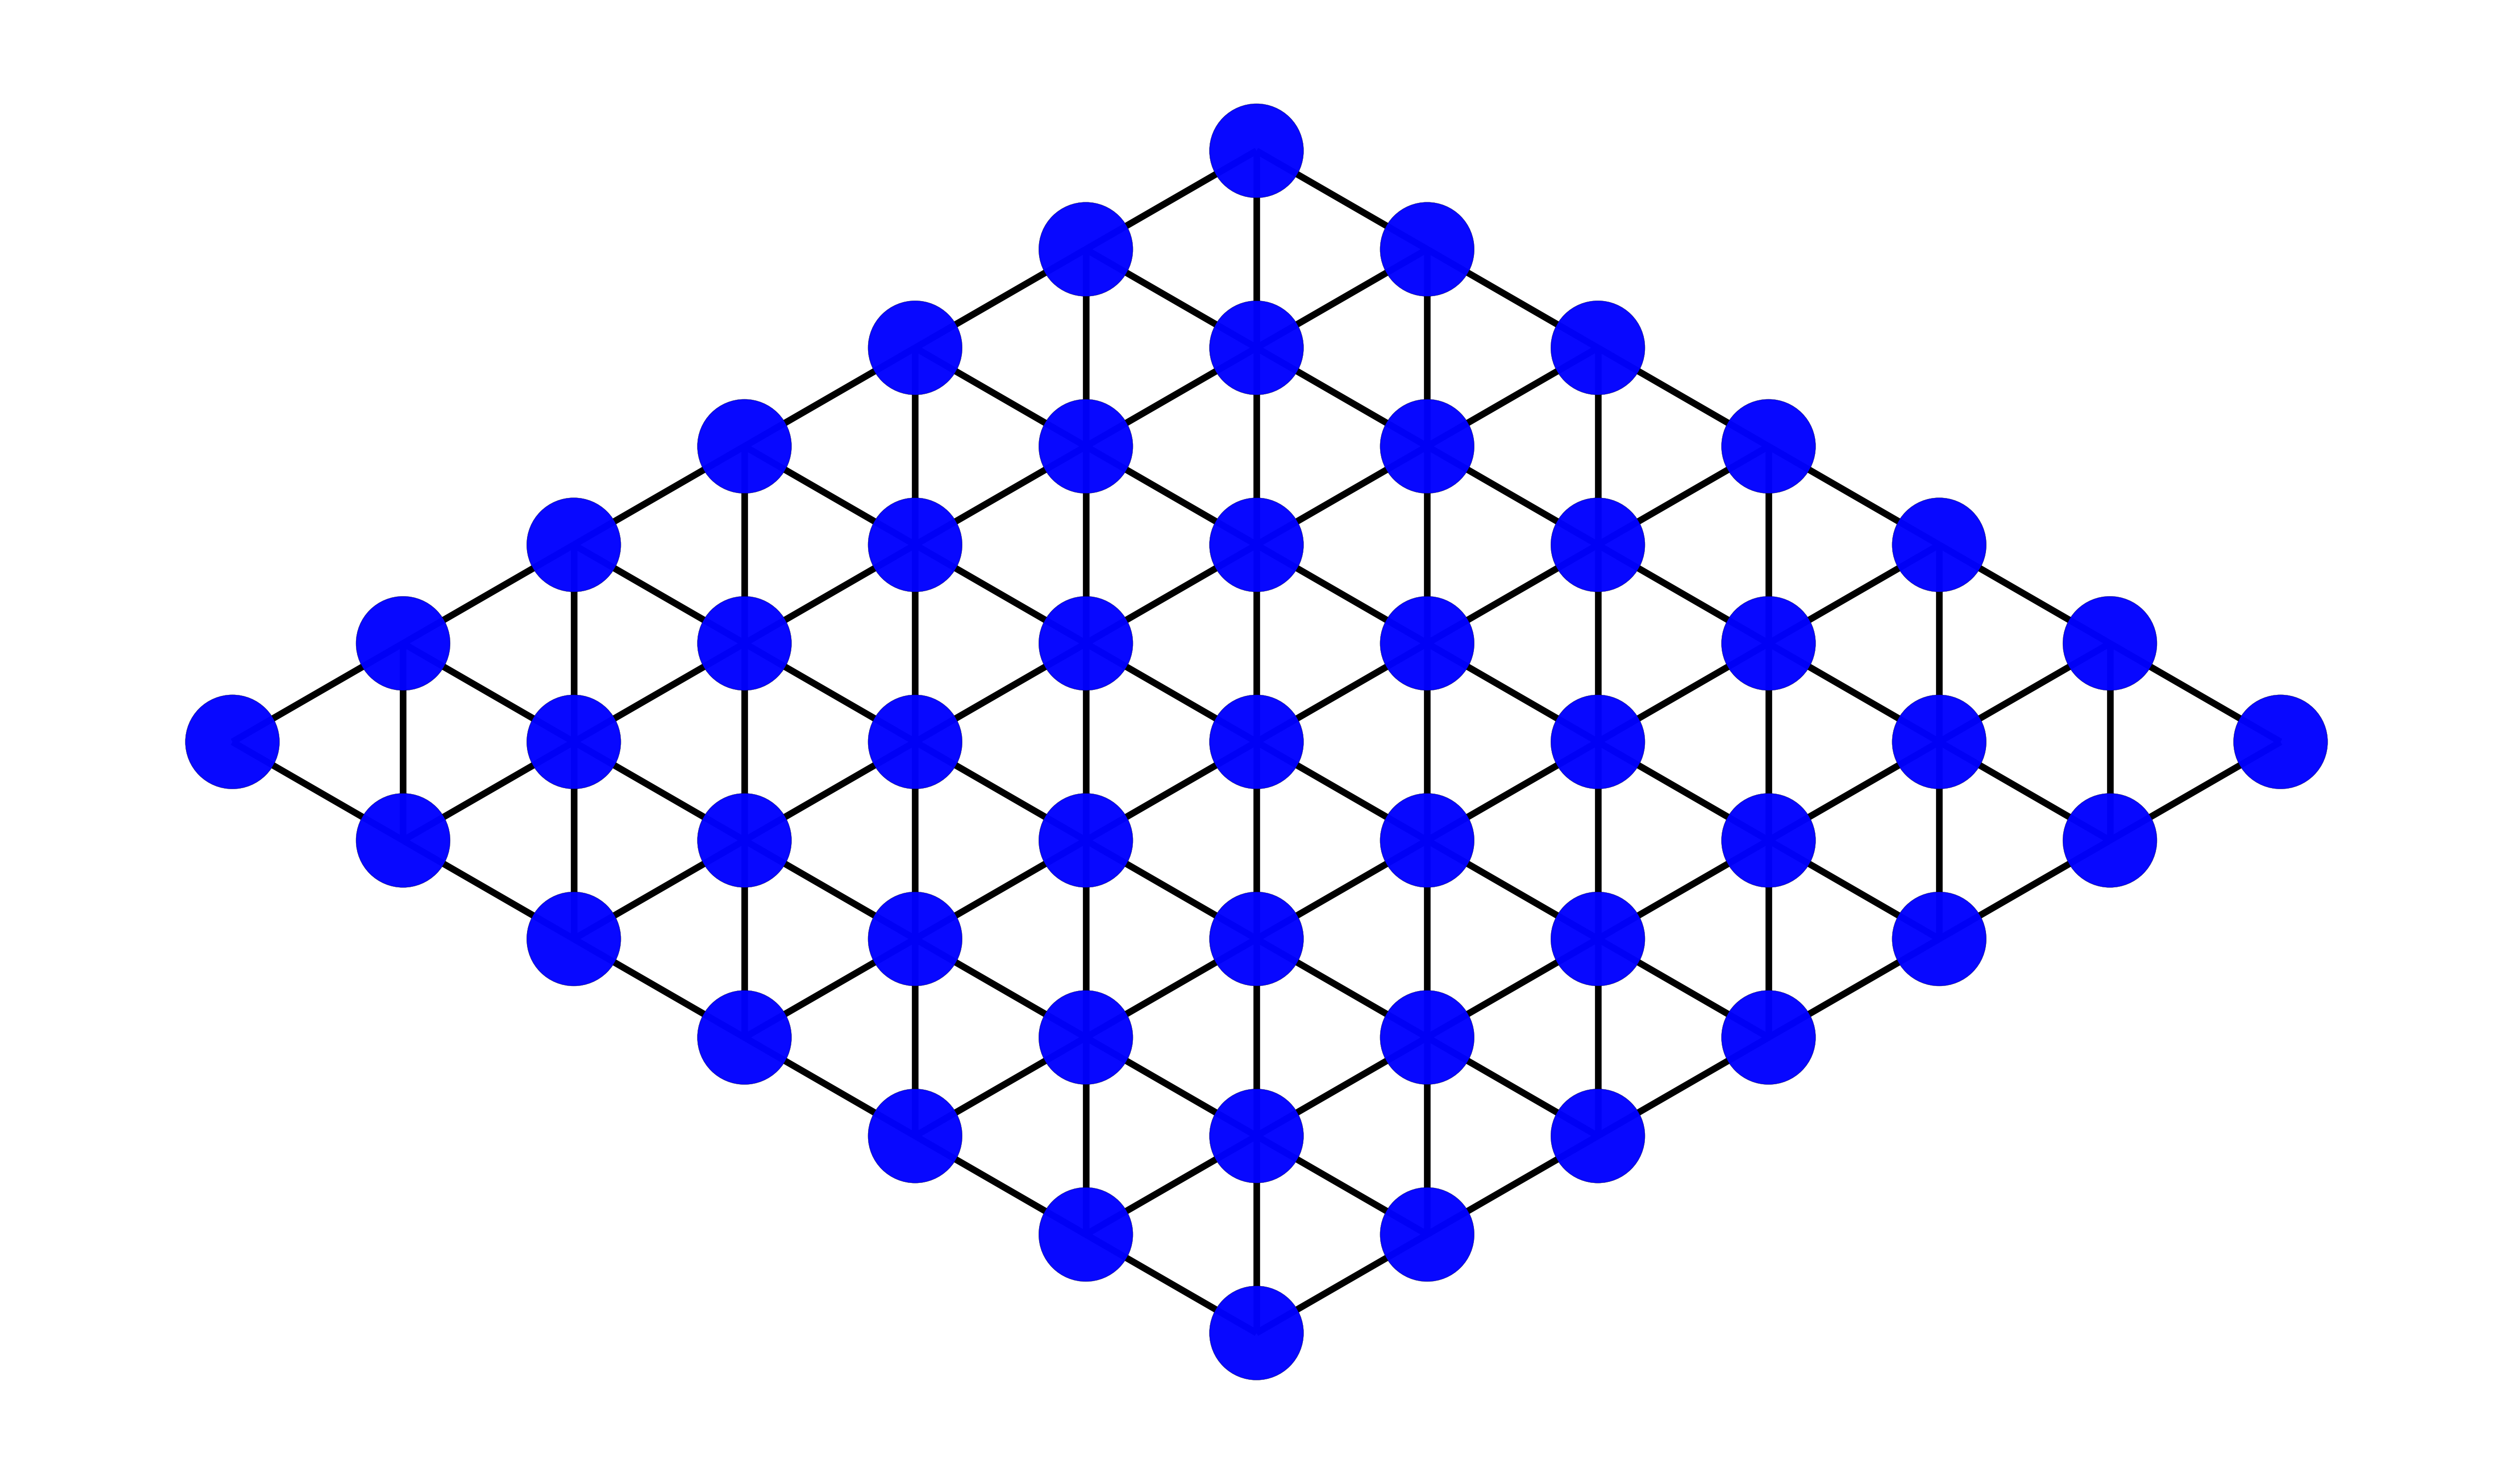

In [5]:
def lattice_hexag():
    a = 1   # [nm] unit cell length
    t = -1.0      # [eV] nearest neighbour hopping
    lat = pb.Lattice(a1 = [3*0.5,np.sqrt(3)*0.5],a2 = [3*0.5,-np.sqrt(3)*0.5])
    lat.add_sublattices(('A', [0, 0]))
    lat.add_hoppings(([0, 1], 'A', 'A', t),
                     ([1, 0], 'A', 'A', t),
                     ([1, -1], 'A', 'A', t),
                    )
    return lat

model = pb.Model(lattice_hexag(), pb.primitive(a1=7, a2=7))

plt.figure(dpi=800)
model.plot(site ={"cmap":["blue"]},hopping={'width': 2,"color":"k"})
plt.yticks([])
plt.xticks([])

plt.ylabel("")
plt.xlabel("")
plt.axis('off')
plt.tight_layout()
plt.savefig("lattice.png")
plt.show()


In [6]:
x,y = create_lattice(40)

([], [])

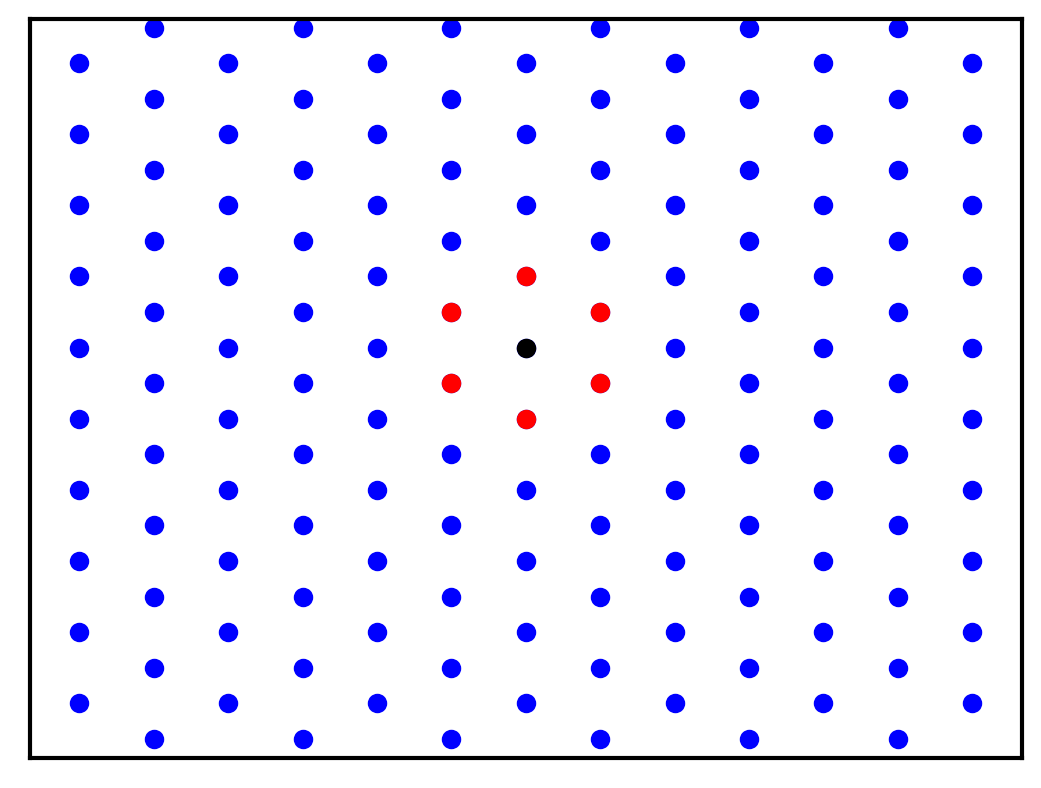

In [7]:
n = 15
a1 = np.array([3,np.sqrt(3)])*0.5
a2 = np.array([3,-np.sqrt(3)])*0.5
x0 = n*a1[0]+n*a2[0]
y0 = n*a1[1]+n*a2[1]

plt.scatter(x,y,color="b")
plt.scatter(x0,y0,color="k")
plt.scatter(x0+a1[0],y0+a1[1],color="r")
plt.scatter(x0-a1[0],y0-a1[1],color="r")
plt.scatter(x0+a2[0],y0+a2[1],color="r")
plt.scatter(x0-a2[0],y0-a2[1],color="r")
plt.scatter(x0+a2[0]-a1[0],y0+a2[1]-a1[1],color="r")
plt.scatter(x0-a2[0]+a1[0],y0-a2[1]+a1[1],color="r")
plt.xlim(35,55)
plt.ylim(-10,8)
plt.yticks([])
plt.xticks([])

# Monte Carlo

## Generate initial grid.
## Function to calculate the initial energy of this config

In [8]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,Y] + grid[(X-1)%N,Y])
            E+= 0.25*J*grid[X,Y] * (grid[X,(Y+1)%N] + grid[X,(Y-1)%N])
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,(Y-1)%N] + grid[(X-1)%N,(Y+1)%N])
    return E

In [9]:
@nb.njit
def MC3_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    E  = np.zeros(Nsteps,dtype=nb.float64)
    M  = np.zeros(Nsteps,dtype=nb.float64)
        
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    M0 = np.sum(init)
    
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            
            E0 += dE
            M0 -=2.*init[X,Y]
            init[X,Y] *= -1
        E[k]  = E0/(N*N)
        M[k] = M0/((N*N)**2)
        
    return E,M

In [10]:
steps = 400_000

init = spins_generator(16)
E16,E16_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(32)
E32,E32_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(64)
E64,E64_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(128)
E128,E128_2 = MC3_step(steps,2,init,1,0)

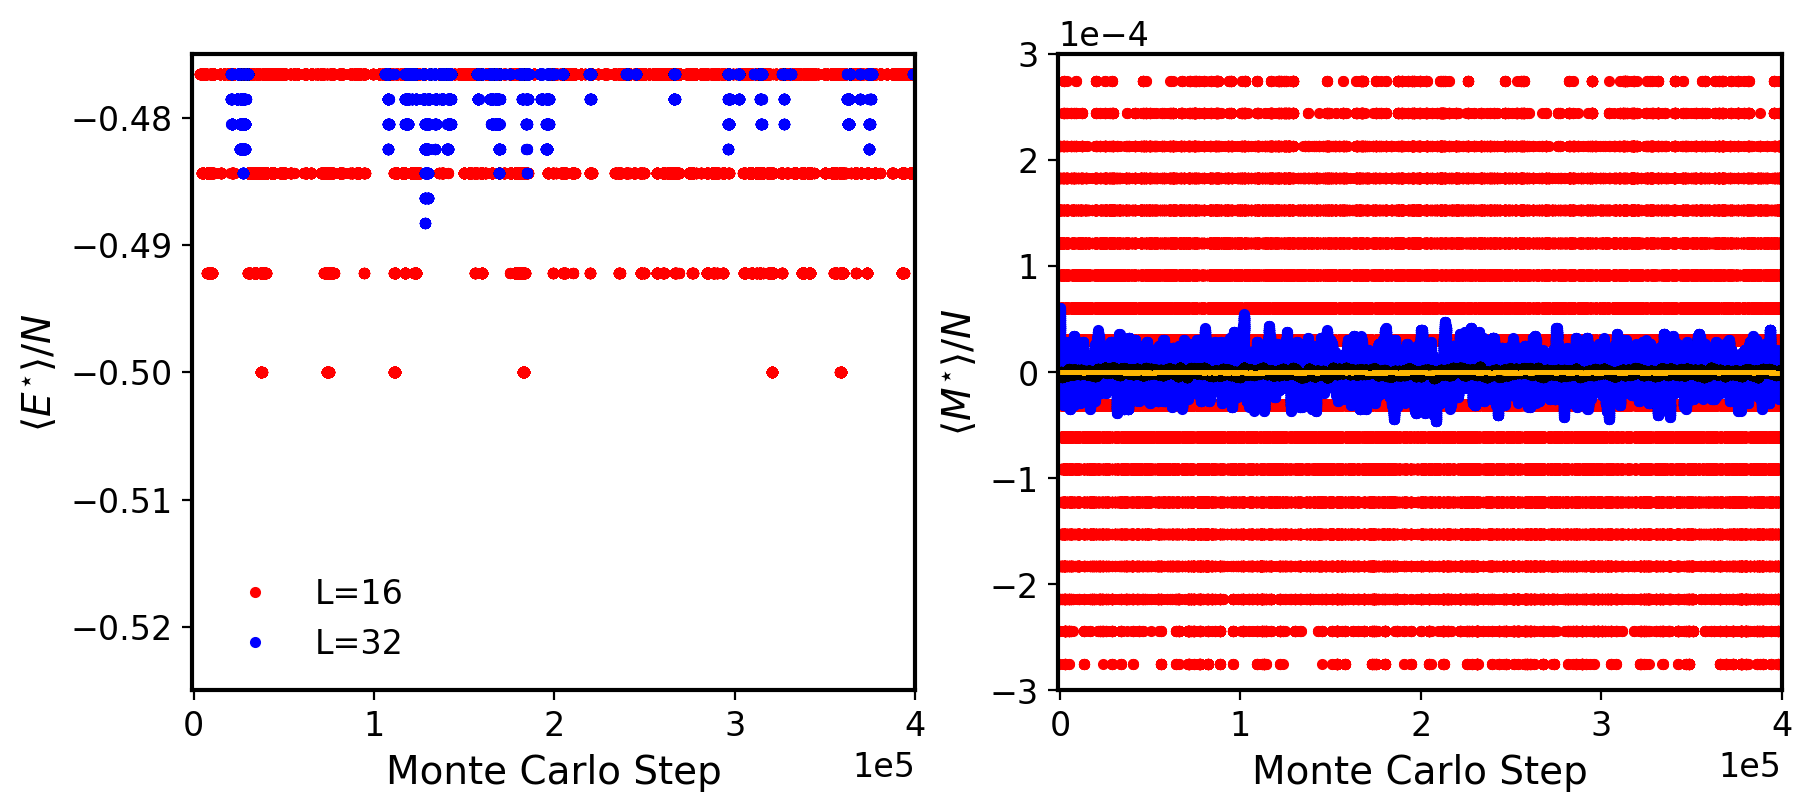

In [11]:
fig,axs = plt.subplots(ncols=2,figsize=(9,4))
axs[0].plot(E16,".",label="L=16")
axs[0].plot(E32,".",label="L=32")
#axs[0].plot(E64,".",label="L=64")
#axs[0].plot(E128,".",label="L=128")
axs[0].legend(frameon=False)


axs[0].ticklabel_format(style='sci',scilimits=(0,0),axis='x')
axs[1].plot(E16_2,".",label="L=16")
axs[1].plot(E32_2,".",label="L=32")
axs[1].plot(E64_2,".",label="L=64")
axs[1].plot(E128_2,".",ms=1,label="L=128")
axs[1].ticklabel_format(style='sci',scilimits=(0,0),axis='x')
axs[1].ticklabel_format(style='sci',scilimits=(0,0),axis='y')


axs[0].set_ylabel(r"$\langle E^{\star} \rangle / N $")
axs[1].set_ylabel(r"$\langle M^{\star} \rangle / N $")


axs[0].set_xlabel("Monte Carlo Step")
axs[1].set_xlabel("Monte Carlo Step")


axs[0].set_xlim(-1000,steps)
axs[0].set_ylim(-0.525,-0.475)

axs[1].set_xlim(-1000,steps)
axs[1].set_ylim(-0.0003,0.0003)
plt.tight_layout(pad=0.5)

plt.savefig("monte_carlo_steps.png")

In [12]:
steps = 10_000_000

init = spins_generator(16)
E16,E16_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(32)
E32,E32_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(64)
E64,E64_2 = MC3_step(steps,2,init,1,0)

init = spins_generator(128)
E128,E128_2 = MC3_step(steps,2,init,1,0)

In [13]:
warm = 1000_00
var = np.array([np.std(E16[warm:]),np.std(E32[warm:]),np.std(E64[warm:]),np.std(E128[warm:])])
sizes= np.array([16*16,32*32,64*64,128*128])
def inv_sqrt(x,c):
    return c/np.sqrt(x)


pov,cov = opt.curve_fit(inv_sqrt,sizes,var)

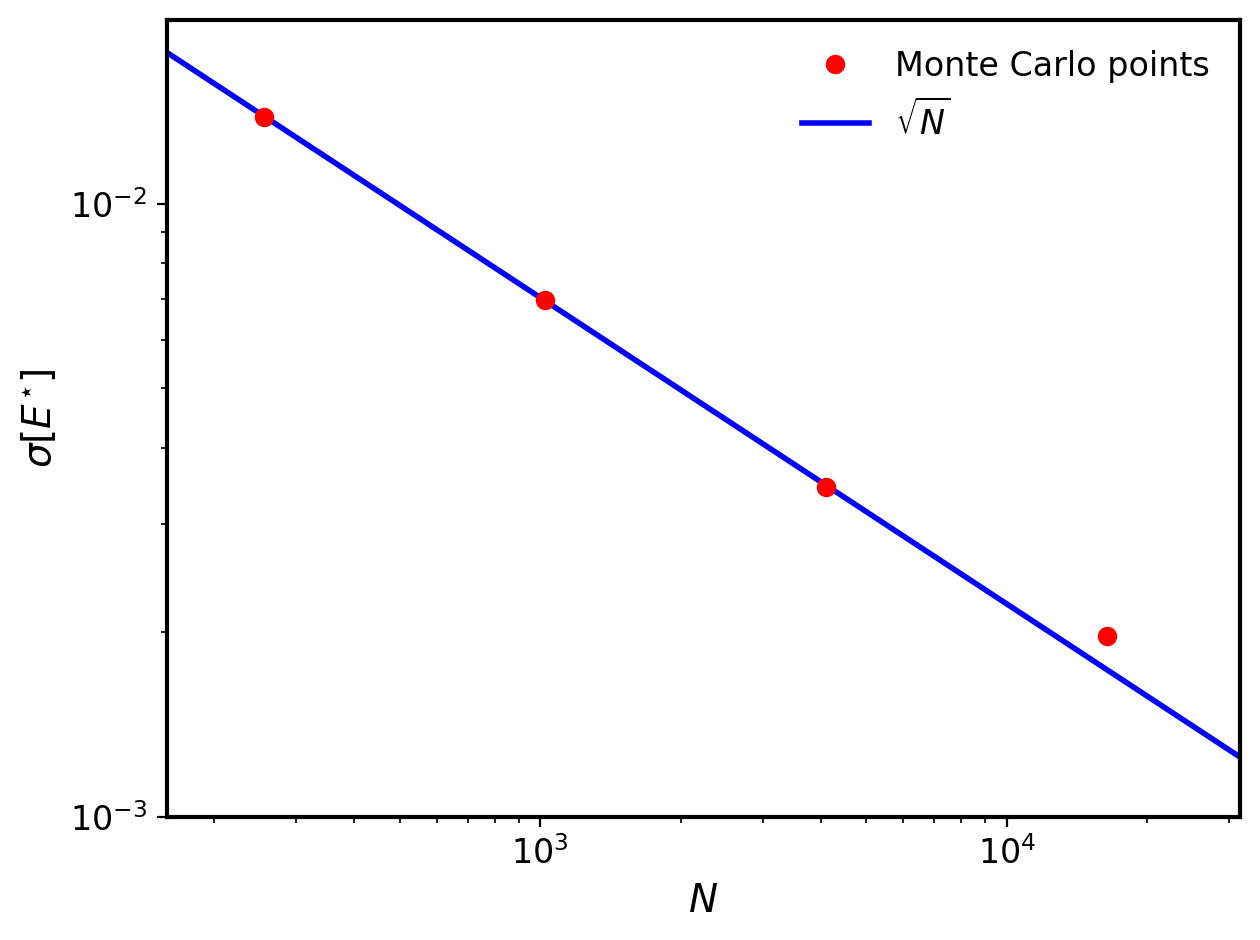

In [14]:
sizess = np.linspace(10*10,200*200,1024)
plt.plot(sizes,var,"r.",ms=12,label=r"Monte Carlo points")
plt.plot(sizess,inv_sqrt(sizess,*pov),"b-",zorder=-1,label=r"$\sqrt{N}$")
plt.yscale("log")
plt.xscale("log")
plt.xlim(10**(2.2),10**(4.5))
plt.ylim(10**(-3),10**(-1.7))
plt.ylabel(r"$\sigma [E^{\star}]$")
plt.xlabel(r"$N$")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("std_energy_system_size.png")

## Testing the Code for the Free Limit

In [15]:
def mean_energy_zero(beta,B):
    return -1*B*np.tanh(B*beta)

def heat_capacity_zero(beta,B):
    return beta*beta*B*B/(np.cosh(B*beta))**2

In [16]:
betas = np.concatenate((np.linspace(0.01,1,16),np.linspace(1,4,32)))

Ener16 = np.zeros(len(betas))
Heat_Capacity = np.zeros(len(betas))
steps = 200000

for i,b in enumerate(betas):
    b = 1/b
    init = spins_generator(1)
    l = len(init)
    E,E2 = MC3_step(steps,b,init,0,1)
    Ener16[i] = np.average(E[:])/(l*l)
    Heat_Capacity[i] = b*b*(np.average(E[:]*E[:])/(l*l) - Ener16[i]*Ener16[i]*(l*l))

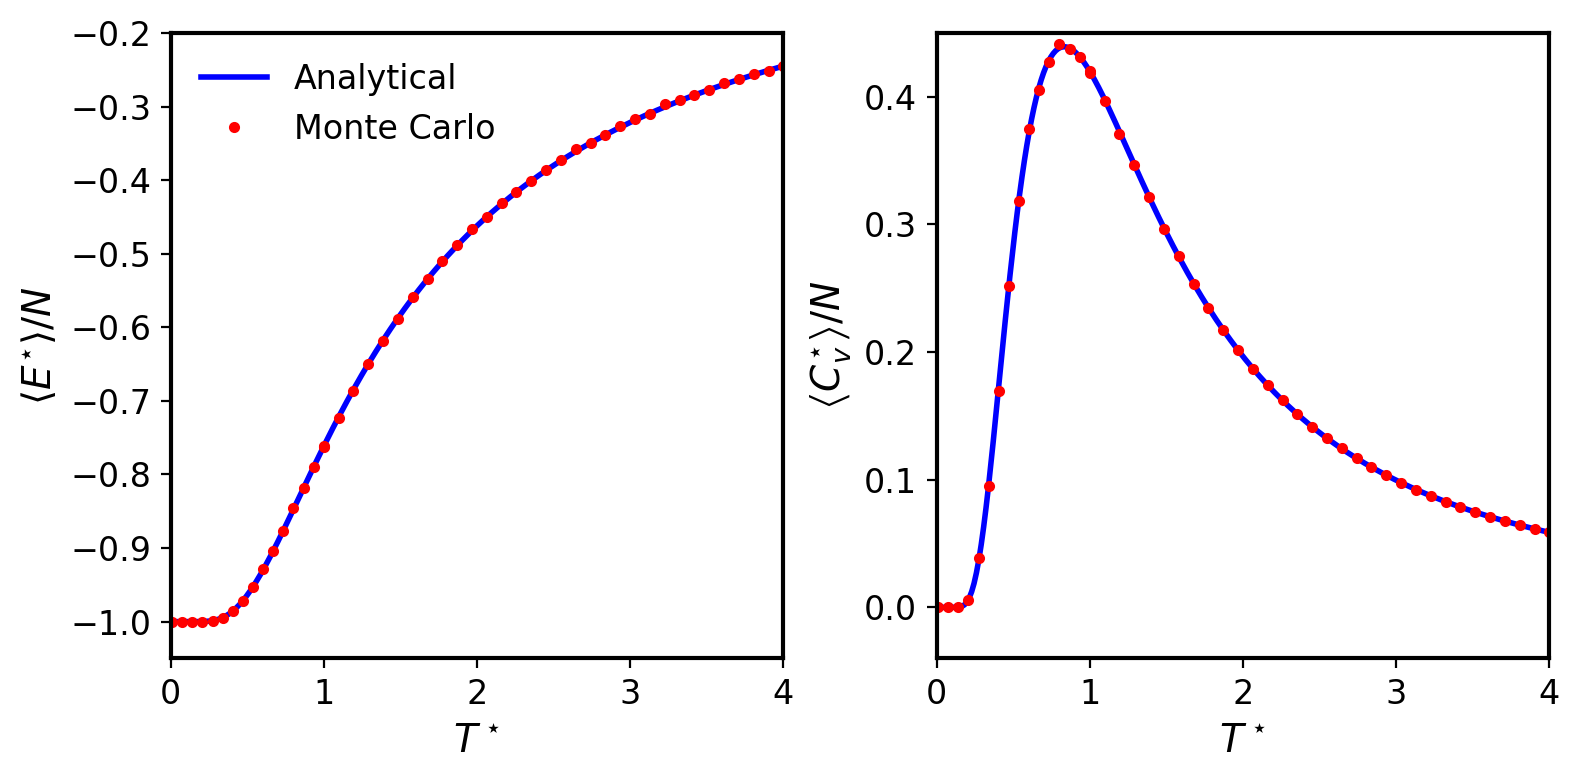

In [17]:
betas2 = np.linspace(0.01,4,256)

fig,axs = plt.subplots(ncols=2,figsize=(8,4))

axs[0].plot(betas2,mean_energy_zero(1/betas2,1),"b",label="Analytical")
axs[0].plot(betas,Ener16,"r.",label="Monte Carlo")

axs[1].plot(betas2,heat_capacity_zero(1/betas2,1),"b",label="Analytical")
axs[1].plot(betas,Heat_Capacity,"r.",label="Monte Carlo")


axs[0].set_xlim(0,4)
axs[0].set_ylim(-1.05,-0.2)
axs[0].set_xlabel(r"$T^\star$")
axs[0].set_ylabel(r"$\left\langle E^{\star} \right\rangle / N $")


axs[1].set_xlim(0,4)
axs[1].set_ylim(-0.04,0.45)

axs[1].set_xlabel(r"$T^\star$")
axs[1].set_ylabel(r"$\left\langle C^{\star}_v \right\rangle / N $")
axs[0].legend(frameon=False)
plt.tight_layout(w_pad=0.5)

plt.savefig("analytical_vs_mc_free_particle.png")

### Checking Neel State for Square Lattice

In [18]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,Y] + grid[(X-1)%N,Y])
            E+= 0.25*J*grid[X,Y] * (grid[X,(Y+1)%N] + grid[X,(Y-1)%N])
           # E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,(Y-1)%N] + grid[(X-1)%N,(Y+1)%N])
    return E

@nb.njit
def MC1_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N   = len(init)
    #array to store the energies:
    E   = np.zeros(Nsteps,dtype=nb.float64)
    E2  = np.zeros(Nsteps,dtype=nb.float64)
    Mag = np.zeros(Nsteps,dtype=nb.float64)
    
    M = np.sum(init)
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        #v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            M -= 2*init[X,Y]
            init[X,Y] *= -1
            
        Mag[k] = M
        E[k]  = E0
        E2[k] = E0*E0
        
    return E,E2,Mag,init

In [19]:
init = spins_generator(32)
E,E2,Mag,neell = MC1_step(1000000,4.0,init,1.0,0.0)
init = spins_generator(32)
E,E2,Mag,neell2 = MC1_step(800000,0.0,init,1.0,0.0)

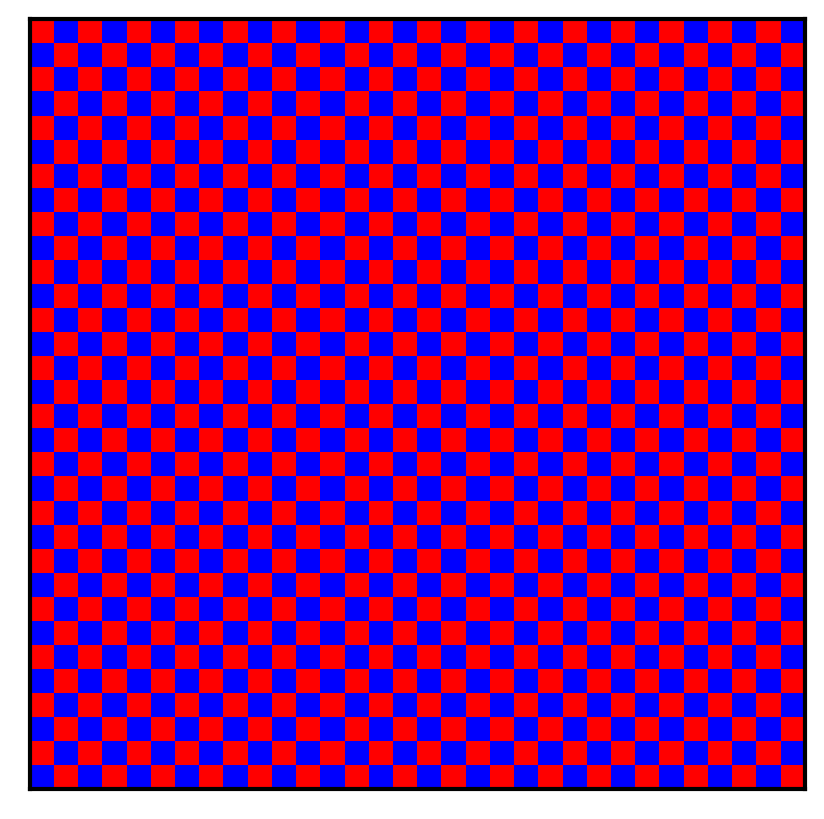

In [20]:
plt.figure(figsize=(5,5))
x,y = create_lattice(10)
plt.pcolormesh(neell,cmap=Mycmap2)
plt.xticks([])
plt.yticks([])
plt.savefig("neel_square_low_temp.png")

# Visualization in the Hexagonal

In [21]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,Y] + grid[(X-1)%N,Y])
            E+= 0.25*J*grid[X,Y] * (grid[X,(Y+1)%N] + grid[X,(Y-1)%N])
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,(Y-1)%N] + grid[(X-1)%N,(Y+1)%N])
    return E

In [22]:
@nb.njit
def MC1_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N   = len(init)
    #array to store the energies:
    E   = np.zeros(Nsteps,dtype=nb.float64)
    E2  = np.zeros(Nsteps,dtype=nb.float64)
    Mag = np.zeros(Nsteps,dtype=nb.float64)
    
    M = np.sum(init)
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            M -= 2*init[X,Y]
            init[X,Y] *= -1
            
        Mag[k] = M/(N*N)
        E[k]  = E0/(N*N)
        E2[k] = E0*E0/(N*N)
        
    return E,E2,Mag,init

In [23]:
init = spins_generator(32)
E,E2,Mag,frust1 = MC1_step(40000000,4,init,1.0,0.0)
init = spins_generator(32)
E,E2,Mag,frust2 = MC1_step(40000000,0,init,1.0,0.0)

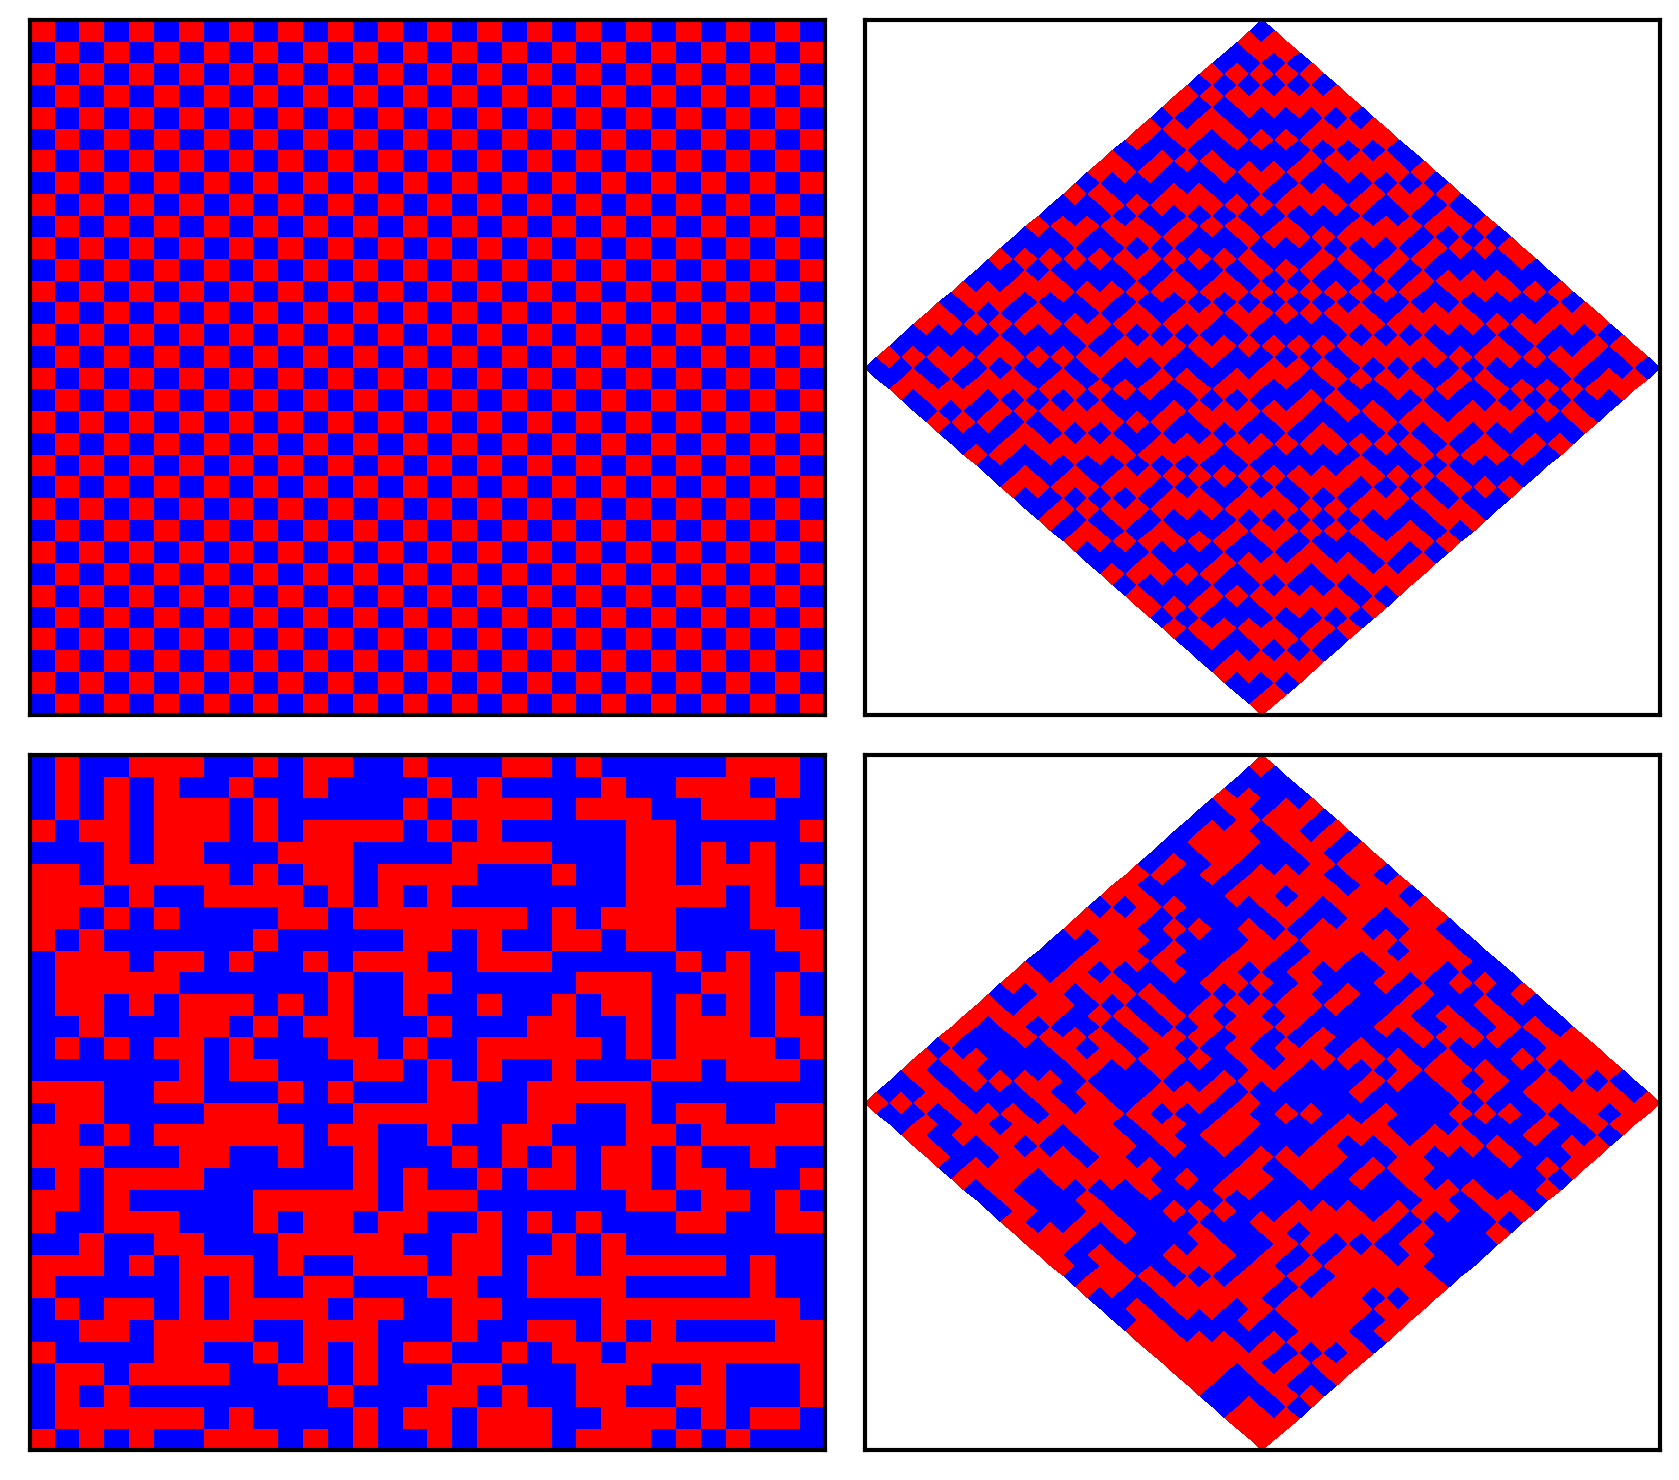

In [24]:
fig,axs = plt.subplots(ncols=2,nrows=2, figsize=(8.5,7.5))

x,y = create_lattice(32)
axs[0][1].pcolormesh(x,y,frust1,cmap=Mycmap2)
axs[0][0].pcolormesh(neell,cmap=Mycmap2)

axs[1][1].pcolormesh(x,y,frust2,cmap=Mycmap2)
axs[1][0].pcolormesh(neell2,cmap=Mycmap2)

axs[0][0].set_xticks([])
axs[0][0].set_yticks([])
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
plt.tight_layout()
plt.savefig("frustaded_neel_square_low_temp.png")

# Question 3 CV

In [25]:
@nb.njit
def Hamiltonian_init(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,Y] + grid[(X-1)%N,Y])
            E+= 0.25*J*grid[X,Y] * (grid[X,(Y+1)%N] + grid[X,(Y-1)%N])
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,(Y-1)%N] + grid[(X-1)%N,(Y+1)%N])
    return E


@nb.njit
def Hamiltonian_Square(grid,J,B):
    E =0
    N = len(grid)
    for X in range(N):
        for Y in range(N):
            E -= B * grid[X,Y]
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,Y] + grid[(X-1)%N,Y])
            E+= 0.25*J*grid[X,Y] * (grid[X,(Y+1)%N] + grid[X,(Y-1)%N])
            E+= 0.25*J*grid[X,Y] * (grid[(X+1)%N,(Y-1)%N] + grid[(X-1)%N,(Y+1)%N])
    return E

In [26]:
@nb.njit
def MCV_step(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    E  = np.zeros(Nsteps)
        
    #initial_energy
    E0 = Hamiltonian_init(init,J,B)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            init[X,Y] *= -1
            
        E[k]  = E0/(N*N)
    return E



@nb.njit
def MCV_step_Square(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    E  = np.zeros(Nsteps)
        
    #initial_energy
    E0 = Hamiltonian_Square(init,J,B)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        #v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            E0 += dE
            init[X,Y] *= -1
            
        E[k]  = E0/(N*N)
    return E

In [27]:
@nb.njit
def energy_vs_temperature(betas,Nsteps,warmup,init,J,B):
    size = len(init)
    En = np.zeros(len(betas))
    stdEn = np.zeros(len(betas))
    for i,b in enumerate(betas):
        E = MCV_step(Nsteps,1./b,init,J,B)
        En[i] = np.average(E[warmup:])
        stdEn[i] = np.std(E[warmup:])
    return En,stdEn

@nb.njit
def heat_capacity_vs_temperature(betas,Nsteps,warmup,init,J,B):
    size = len(init)
    Cv = np.zeros(len(betas))
    stdCv = np.zeros(len(betas))
    for i,b in enumerate(betas):
        E = MCV_step(Nsteps,1./b,init,J,B)
        Ed = np.average(E[warmup:])
        Cv[i] = (1./b)*(1./b)*(np.average(E[warmup:]*E[warmup:]) - Ed*Ed)*(size*size)
        stdCv[i] = (1./b)*(1./b)*np.std(E[warmup:]*E[warmup:]) + 2*np.abs(Ed)*np.std(E[warmup:])
    return Cv,stdCv



@nb.njit
def heat_capacity_vs_temperature_square(betas,Nsteps,warmup,init,J,B):
    
    size = len(init)
    
    Cv = np.zeros(len(betas))
    
    stdCv = np.zeros(len(betas))
    
    for i,b in enumerate(betas):
        
        E = MCV_step_Square(Nsteps,1./b,init,J,B)
        
        Ed = np.average(E[warmup:])
        
        Cv[i] = (1./b)*(1./b)*(np.average(E[warmup:]*E[warmup:]) - Ed*Ed)*(size*size)
        
        stdCv[i] = (1./b)*(1./b)*np.std(E[warmup:]*E[warmup:]) + 2*np.abs(Ed)*np.std(E[warmup:])
    
    return Cv,stdCv

In [28]:
temp = np.linspace(0.01,4,64)


Nsteps = 580_000

init = spins_generator(32)
En32,stdEn32 = energy_vs_temperature(temp,Nsteps,100_000,init,J=1,B=0)


init = spins_generator(64)
En64,stdEn64 = energy_vs_temperature(temp,Nsteps,100_000,init,J=1,B=0)

In [29]:
Nsteps = 1_000_000
init = spins_generator(128)
En128,stdEn128 = energy_vs_temperature(temp,Nsteps,500_000,init,J=1,B=0)

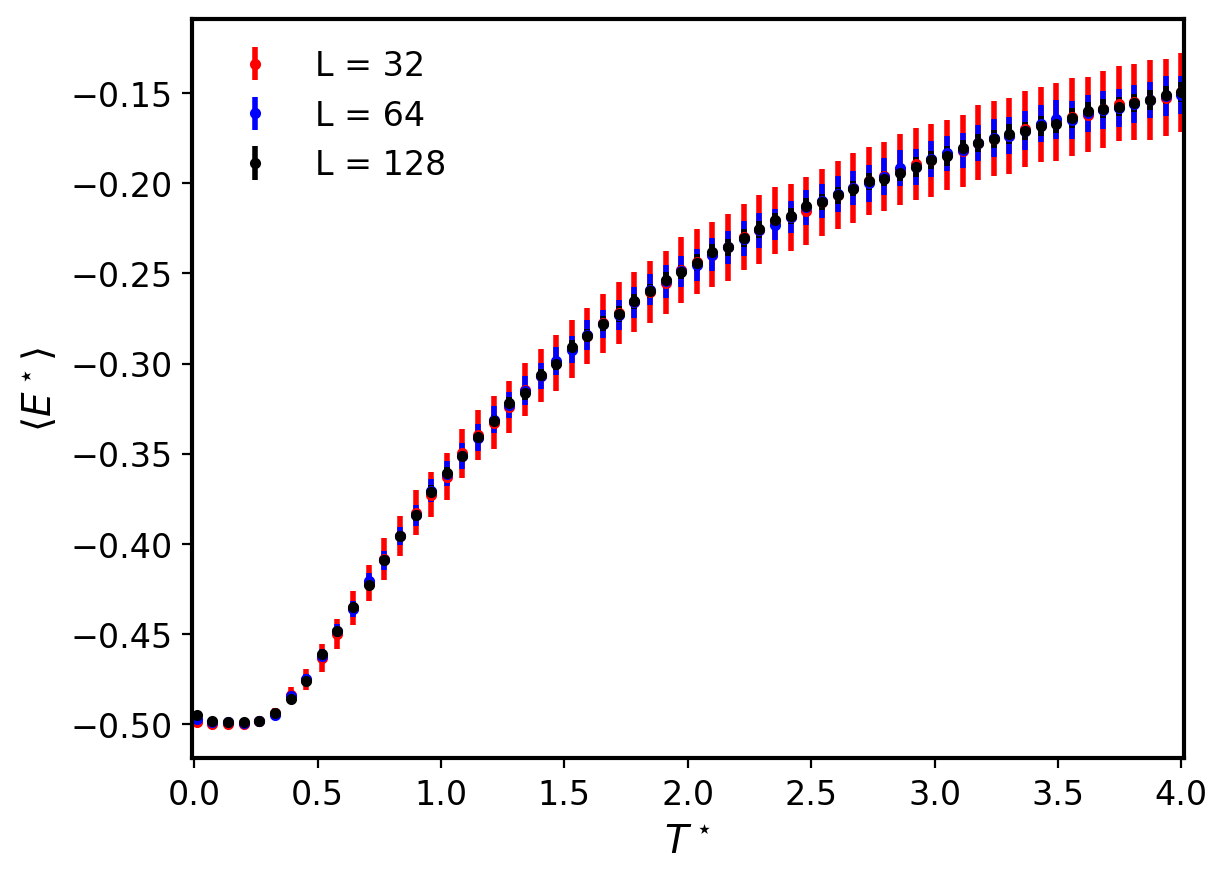

In [30]:
plt.errorbar(temp,En32,yerr=stdEn32,fmt=".",label="L = 32")
plt.errorbar(temp,En64,yerr=stdEn64,fmt=".",label="L = 64")
plt.errorbar(temp,En128,yerr=stdEn128,fmt=".",label="L = 128")
plt.xlabel(r"$T^\star$")
plt.ylabel(r"$\langle E^\star \rangle$")
plt.legend(frameon=False)

plt.xlim(-0.01,4.01)
plt.savefig("energy_temp.png")

## CV

In [31]:
betas = np.concatenate((np.linspace(0.1,0.8,16),np.linspace(0.8,3,32)))

betas2 = np.linspace(0.5,2,64)

In [32]:
Nsteps = 5_000_000

init = spins_generator(32)
cv32,std32 = heat_capacity_vs_temperature(betas,Nsteps,500_000,init,J=1,B=0)

init = spins_generator(32)
cv32square,std32square = heat_capacity_vs_temperature_square(betas2,Nsteps,500_000,init,J=1,B=0)

##################################################################################################

init = spins_generator(64)
cv64,std64 = heat_capacity_vs_temperature(betas,Nsteps,500_000,init,J=1,B=0)

init = spins_generator(64)
cv64square,std64square = heat_capacity_vs_temperature_square(betas2,Nsteps,500_000,init,J=1,B=0)

In [33]:
betas3 = np.linspace(0.1,1.0,20)
Nsteps = 5_000_000

init = spins_generator(32)
cv32b,std32b = heat_capacity_vs_temperature(betas3,Nsteps,1_000_000,init,J=1,B=0)

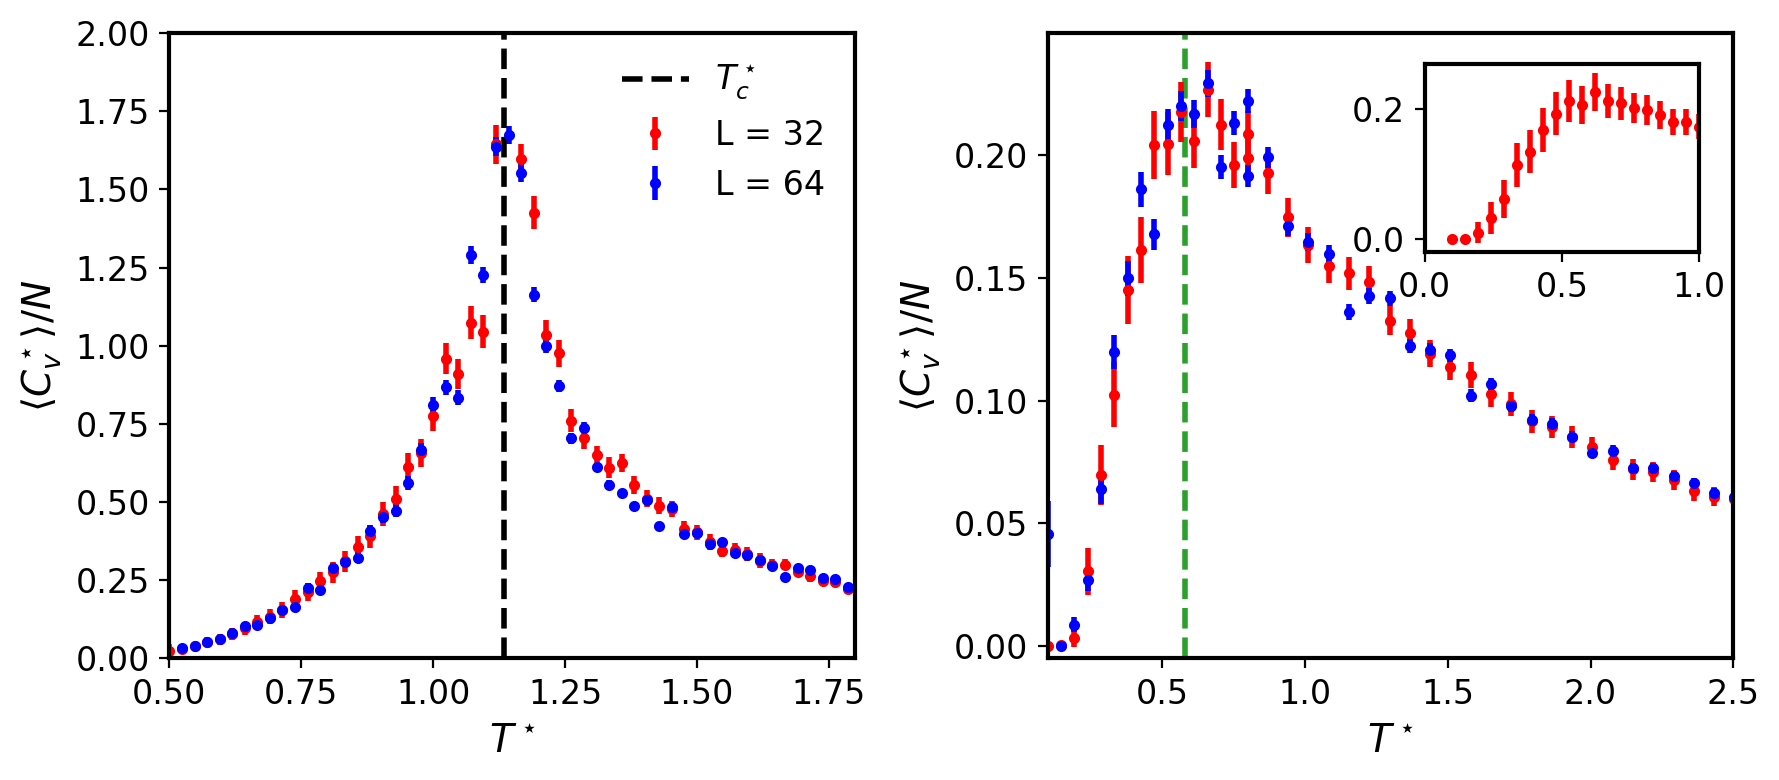

In [34]:
fig,axs = plt.subplots(ncols=2,figsize=(9,4))

axs[0].errorbar(betas2,cv32square,yerr=std32square,fmt=".",label="L = 32")
axs[0].errorbar(betas2,cv64square,yerr=std64square,fmt=".",label="L = 64")

axs[0].axvline(x=1.1345,color="k",ls="--",label=r"$T^\star_c$")
axs[0].set_xlabel(r"$T^\star$")
axs[0].set_ylabel(r"$\langle C^\star_v \rangle / N $")
axs[0].set_xlim(0.5,1.8)
axs[0].set_ylim(0,2)


axs[1].axvline(x=0.58,color="tab:green",ls="--",label=r"$T^\star_c$")
axs[1].errorbar(betas,cv32,yerr=std32*0.4,fmt=".",label="L = 32")
axs[1].errorbar(betas,cv64,yerr=std64*0.4,fmt=".",label="L = 64")
axs[1].set_xlabel(r"$T^\star$")
axs[1].set_ylabel(r"$\langle C^\star_v \rangle / N $")
axs[1].set_xlim(0.1,2.5)
axs[1].set_ylim(-0.005,)

axins = axs[1].inset_axes([0.55, 0.65, 0.4, 0.3])
axins.errorbar(betas3,cv32b,yerr=std32b,fmt=".")
axins.set_xlim(0,1.0)
#axins.set_ylim(-0.01,0.042)
#axs[1].indicate_inset_zoom(axins, edgecolor="black")
#axins.set_xticks([])

axs[0].legend(frameon=False)
plt.tight_layout()
plt.savefig("cv_temp.png")

## Magnetic Suscptibility

In [35]:
@nb.njit
def MCV_step_mag(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    M = np.zeros(Nsteps)
        
    #initial_energy
    M0 = np.sum(init)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            M0 -=2.*init[X,Y]
            init[X,Y] *= -1

        M[k]  = M0/(N*N)
    return M


@nb.njit
def MCV_step_mag_square(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    M = np.zeros(Nsteps)
        
    #initial_energy
    M0 = np.sum(init)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        #v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            M0 -=2.*init[X,Y]
            init[X,Y] *= -1

        M[k]  = M0/(N*N)
    return M

In [36]:
@nb.njit
def magnetic_susceptibility_vs_temperature(betas,Nsteps,warmup,init,J,B):
    size = len(init)
    Cv = np.zeros(len(betas))
    stdCv = np.zeros(len(betas))
    for i,b in enumerate(betas):
        m = MCV_step_mag(Nsteps,1./b,init,J,B)
        md = np.average(m[warmup:])
        Cv[i] = (1/b)*(np.average(m[warmup:]*m[warmup:]) - md*md)*(size*size)
        stdCv[i] = (1/b)*np.std(m[warmup:]*m[warmup:]) +2.*np.abs(md)*np.std(m[warmup:])
    return Cv,stdCv


@nb.njit
def magnetic_susceptibility_vs_temperature_square(betas,Nsteps,warmup,init,J,B):
    size = len(init)
    Cv = np.zeros(len(betas))
    stdCv = np.zeros(len(betas))
    for i,b in enumerate(betas):
        m = MCV_step_mag_square(Nsteps,1./b,init,J,B)
        md = np.average(m[warmup:])
        Cv[i] = (1/b)*(np.average(m[warmup:]*m[warmup:]) - md*md)*(size*size)
        stdCv[i] = (1/b)*np.std(m[warmup:]*m[warmup:]) +2.*np.abs(md)*np.std(m[warmup:])
    return Cv,stdCv

In [55]:
betas = np.concatenate((np.linspace(0.2,1,16),np.linspace(1,5,32)))

In [38]:
Nsteps = 4_000_000
betas = np.concatenate((np.linspace(0.2,1,16),np.linspace(1,5,32)))

init = spins_generator(32)
xi32,stdxi32 = magnetic_susceptibility_vs_temperature(betas,Nsteps,500_000,init,J=1,B=0)

init = spins_generator(64)
xi64,stdxi64 = magnetic_susceptibility_vs_temperature(betas,Nsteps,500_000,init,J=1,B=0)

In [56]:
betas2 = np.concatenate((np.linspace(0.8,1.1,16),np.linspace(1.1,5,32)))

In [40]:
Nsteps = 4_000_000

init = spins_generator(32)
xi32square,stdxi32square = magnetic_susceptibility_vs_temperature_square(betas2,Nsteps,1_000_00,init,J=1,B=0)

init = spins_generator(64)
xi64square,stdxi64square = magnetic_susceptibility_vs_temperature_square(betas2,Nsteps,1_000_00,init,J=1,B=0)

In [57]:
def lin_fit(x,m,b):
    return x*m + b

In [64]:
M = 16
pov,cov = opt.curve_fit(lin_fit,betas[M:],1/xi32[M:])

M = 32
pov2,cov2 = opt.curve_fit(lin_fit,betas2[M:],1/xi64square[M:])

print(pov)
print(np.sqrt(np.diag(cov)))

x = pov[1]/pov[0]
print("Theta =",-pov[1]/pov[0])

print("Theta =",x*np.sqrt((cov[0]/pov[0])**2 +(cov[1]/pov[1])**2 ))

print("-------------------------")
print(pov2)
print(np.sqrt(np.diag(cov2)))
print("Theta =",-pov2[1]/pov2[0])
x = pov2[1]/pov2[0]
print("Theta =",x*np.sqrt((cov2[0]/pov2[0])**2 +(cov2[1]/pov2[1])**2 ))


[0.89286692 3.7525387 ]
[0.0116999  0.03776615]
Theta = -4.20279731601408
Theta = [0.00079166 0.00250766]
-------------------------
[0.84084033 2.93079192]
[0.06557456 0.26870473]
Theta = -3.485551080383207
Theta = [0.02735077 0.1122572 ]


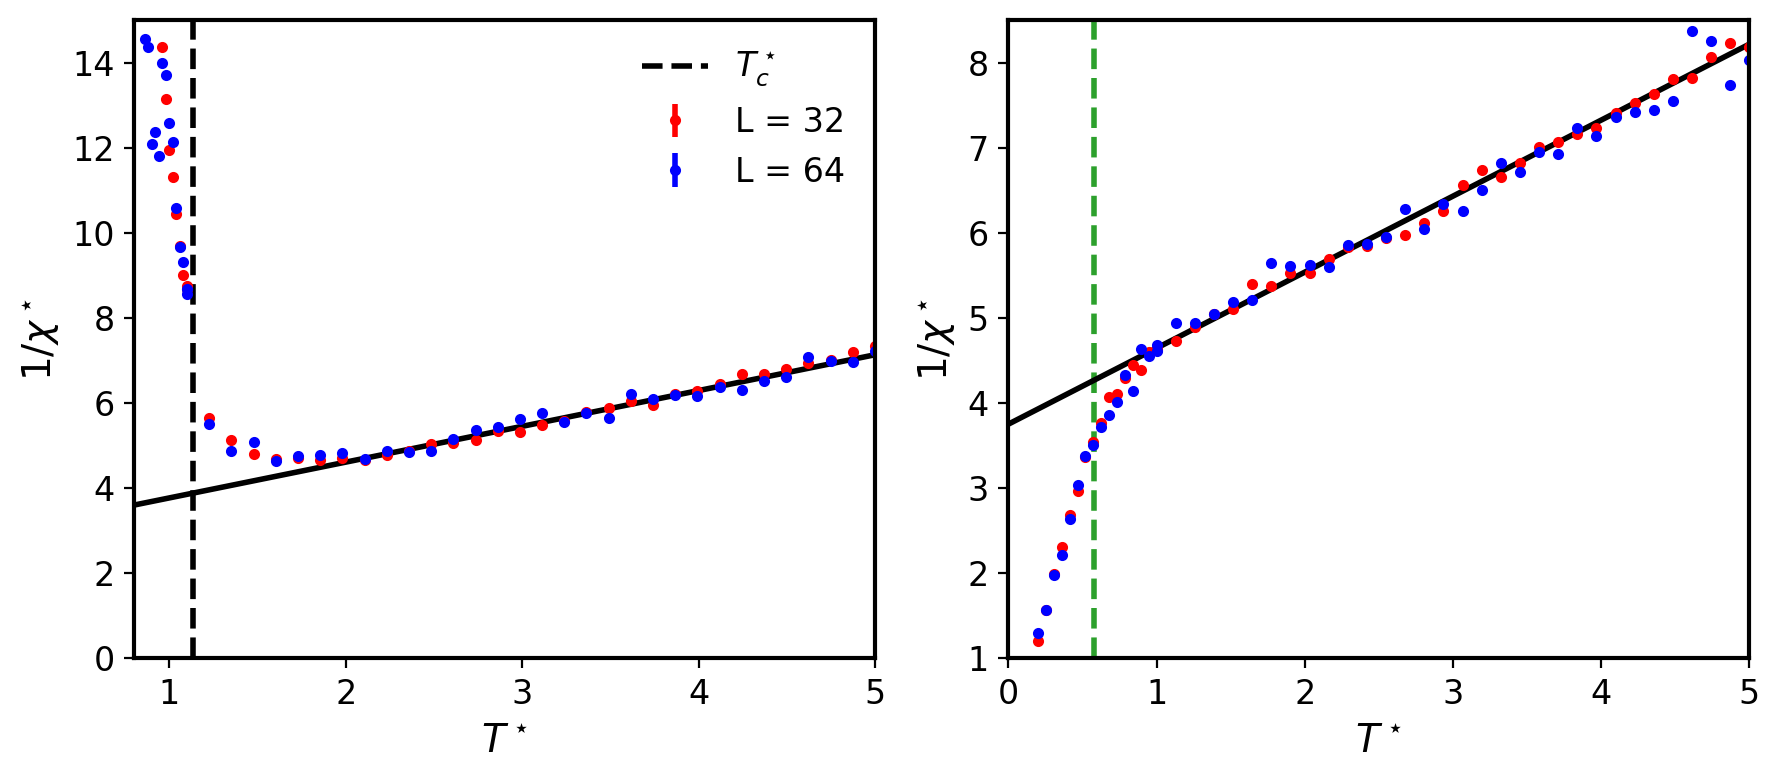

In [62]:
fig,axs = plt.subplots(ncols=2,figsize=(9,4))

bet = np.linspace(0,5)

axs[0].errorbar(betas2,1/xi32square,yerr = (stdxi32square)/(xi32square*xi32square),fmt=".",label="L = 32")

axs[0].errorbar(betas2,1/xi64square,yerr = (stdxi64square)/(xi64square*xi64square),fmt=".",label="L = 64")

axs[0].plot(bet,lin_fit(bet,*pov2),"-",zorder=-1)

axs[0].axvline(x=1.1345,color="k",ls="--",label=r"$T^\star_c$")
axs[0].set_xlabel(r"$T^\star$")
axs[0].set_ylabel(r"1/$\chi^\star$")
axs[0].set_xlim(0.8,5)
axs[0].set_ylim(0,15)


axs[1].axvline(x=0.58,color="tab:green",ls="--",label=r"$T^\star_c$")
axs[1].errorbar(betas,1/xi32,yerr=stdxi32/(xi32*xi32),fmt=".",label="L = 32")
axs[1].errorbar(betas,1/xi64,yerr=stdxi64/(xi64*xi64),fmt=".",label="L = 64")

axs[1].plot(bet,lin_fit(bet,*pov),"-",label="L = 16")

axs[1].set_xlim(0,5)
axs[1].set_ylim(1,8.5)
axs[1].set_xlabel(r"$T^\star$")
axs[1].set_ylabel(r"1/$\chi^\star$")

axs[0].legend(frameon=False)
plt.tight_layout()
plt.savefig("xi_temp.png")

# Question 5

In [44]:
@nb.njit
def magnetic_m_vs_field(beta,BSS,Nsteps,warmup,init,J):
    size = len(init)
    Cv = np.zeros(len(BSS))
    err = np.zeros(len(BSS))
    for i,b in enumerate(BSS):
        m = MCV_step_mag(Nsteps,1./beta,init,J,b)
        Cv[i] =np.average(m[warmup:])
        err[i] =np.std(m[warmup:])
    return Cv,err

In [66]:
Bfields = np.linspace(-10,10,32)

In [45]:
Nsteps = 500_000

Bfields = np.linspace(-10,10,32)
breduc = 2.0

init = spins_generator(64)
mag16,err16 = magnetic_m_vs_field(breduc,Bfields,Nsteps,100_000,init,J=1)


Nsteps = 10_000_000
init = spins_generator(64)
mag32,err32 = magnetic_m_vs_field(0.7,Bfields,Nsteps,500_000,init,J=1)


In [46]:
def tanhss(x,m,C):
    return C*np.tanh(m*x)

In [47]:
pov3,cov3 = opt.curve_fit(tanhss,Bfields,mag16)
print(pov3)
print(np.sqrt(np.diag(cov3)))

[0.19029161 1.08187732]
[0.00546734 0.0141459 ]


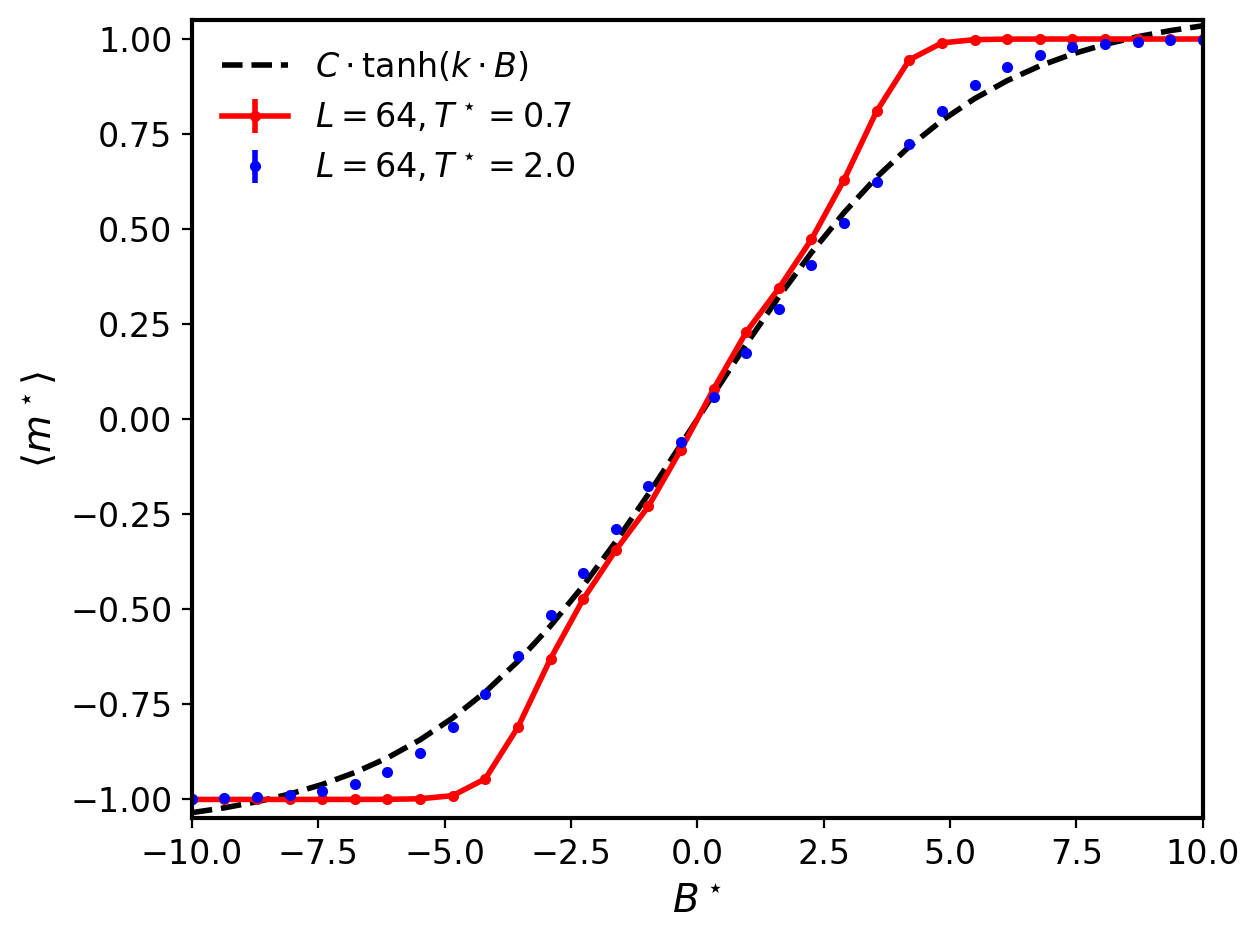

In [67]:
plt.plot(Bfields,tanhss(Bfields,*pov3),"k--",label=r"$C\cdot\tanh(k \cdot B)$",zorder=-1)
plt.errorbar(Bfields,mag32,yerr=err32,fmt=".-",label="$L = 64, T^\star = 0.7$")
plt.errorbar(Bfields,mag16,yerr=err16,fmt=".",label="$L = 64, T^\star = 2.0$")


plt.xlabel(r"$B^\star$")
plt.ylabel(r"$\langle m^\star \rangle $")
plt.xlim(-10,10)
plt.ylim(-1.05,1.05)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("magnetic_field.png")

In [49]:
@nb.njit
def neel_calcf(grid,L):
    S = 0
    for i in range(L):
        for j in range(L):
            S += (-1)**(i+j) * grid[i,j]      
    return S

@nb.njit
def MCV_step_neel(Nsteps,beta,init,J=1,B=0):
    """
    N:= Number of Mc steps;
    beta:= inverse temperature;
    J = exchange term, set to 1 default
    B = magnetic field set to 0 default.
    """
    
    N  = len(init)
    #array to store the energies:
    M = np.zeros(Nsteps)
        
    #initial_energy
    M0 = neel_calcf(init,N)
    for k in range(Nsteps):
        ## Metropolis step
        X,Y = rd.randint(0,N,2)
        #calculate the total change of energy:
        v  = init[X,Y] * (init[(X+1)%N,Y] + init[(X-1)%N,Y])
        v += init[X,Y] * (init[X,(Y+1)%N] + init[X,(Y-1)%N])
        #v += init[X,Y] * (init[(X+1)%N,(Y-1)%N] + init[(X-1)%N,(Y+1)%N])
        
        dE = 2*B*init[X,Y] - J*v
        
        if rd.random() < np.exp(-beta*dE):
            M0 = neel_calcf(init,N)
            init[X,Y] *= -1

        M[k]  = M0/(N*N)
    return M

In [50]:
@nb.njit
def phase_diagram(betas,BSS,Nsteps,warmup,init,J):
    size = len(init)
    Os = np.zeros((len(BSS),len(betas)))
    for i,b in enumerate(BSS):
        for j,t in enumerate(betas):
            m = MCV_step_mag(Nsteps,1/t,init,J,b)
            Os[i,j] =np.average(np.abs(m[warmup:]))
    return Os


@nb.njit
def phase_diagram_square(betas,BSS,Nsteps,warmup,init,J):
    size = len(init)
    Os = np.zeros((len(BSS),len(betas)))
    for i,b in enumerate(BSS):
        for j,t in enumerate(betas):
            m = MCV_step_mag_square(Nsteps,1/t,init,J,b)
            Os[i,j] =np.average(np.abs(m[warmup:]))
    return Os


@nb.njit
def phase_diagram_neel(betas,BSS,Nsteps,warmup,init,J):
    size = len(init)
    Os = np.zeros((len(BSS),len(betas)))
    for i,b in enumerate(BSS):
        for j,t in enumerate(betas):
            m = MCV_step_neel(Nsteps,1/t,init,J,b)
            Os[i,j] =np.average(np.abs(m[warmup:]))
    return Os

In [51]:
Nsteps = 200_000

Bfields = np.linspace(0,5,32)
betas = np.linspace(0.5,10,32)

init = spins_generator(8)
cv8 = phase_diagram(betas,Bfields,Nsteps,10_000,init,J=1)

init = spins_generator(8)
m8_square = phase_diagram_square(betas,Bfields,Nsteps,10_000,init,J=1)



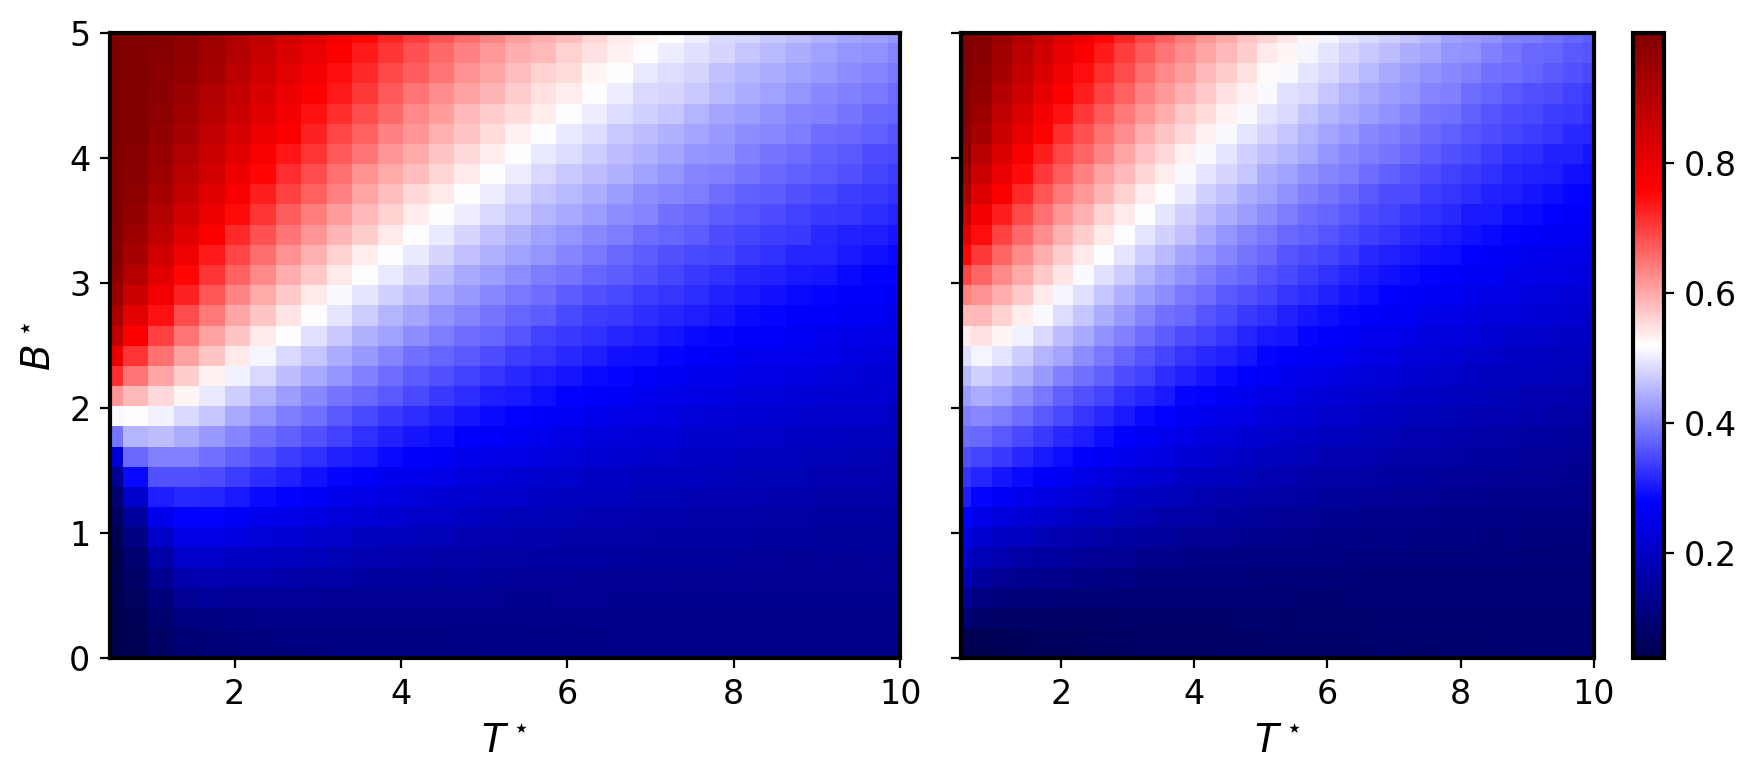

In [52]:
fig,axs = plt.subplots(ncols=2,figsize=(9,4),sharey=True)

axs[0].pcolormesh(betas,Bfields,m8_square,cmap="seismic")

c = axs[1].pcolormesh(betas,Bfields,cv8,cmap="seismic")

axs[0].set_xlabel(r"$T^\star$")
axs[1].set_xlabel(r"$T^\star$")

axs[0].set_ylabel(r"$B^\star$")

axs[0].set_xlim(0.5,10)
axs[1].set_xlim(0.5,10)
axs[0].set_ylim(0,5)
plt.colorbar(c)
plt.tight_layout()
plt.savefig("phase_diagram.png")

In [53]:
Bfields2 = np.linspace(0,3,50)
betas2 = np.linspace(0.5,2,50)

init = spins_generator(8)
m8_square_neel = phase_diagram_neel(betas2,Bfields2,Nsteps,10_000,init,J=1)

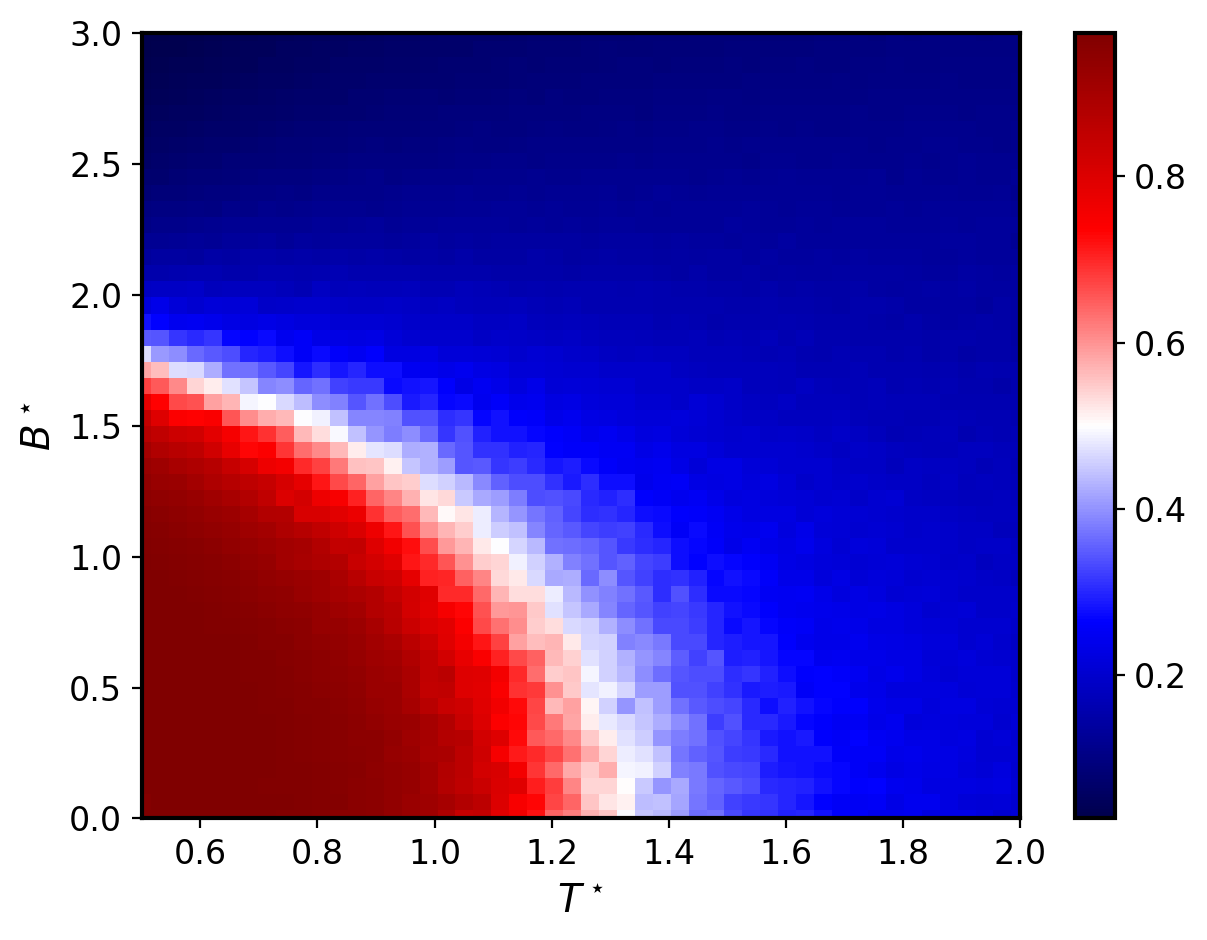

In [54]:
plt.pcolormesh(betas2,Bfields2,m8_square_neel,cmap="seismic")
plt.ylabel(r"$B^\star$")
plt.xlabel(r"$T^\star$")
plt.colorbar()
plt.tight_layout()
plt.xlim(0.5,2)
plt.ylim(0,3)
plt.tight_layout()
plt.savefig("neel.png")